# Filter Delta2 Data Caulobacter crescentus 
 
In this notebook we filter the time-lapse data of Caulobacter crescentus mutant strains with cdg sensor growing on agar-pads

---

## Import packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns
import pathlib

---

## Setup Folders

In [2]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'switchdrive', 'Biozentrum', 'Andreas')
data_dir = proj_dir / 'data_files'
image_dir = proj_dir / 'figures_Cc_Fast'
save_dir = pathlib.Path() / 'data_files'

---

## Load Data

We also add a unique ID for each cell pair (two cells with shared parent) by combining strain id, replicate id, and par id

In [3]:
#load data frame
df_name = data_dir / 'caulobacter_fast_combined_data_low_dens.csv'
df = pd.read_csv(df_name, index_col=0)

#add unique id of cell by combining strain and replicate
df['uni_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_cell'].map(str)
df['uni_par_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_par'].map(str)
df.head()


,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,new_pole,old_pole,...,fluo2,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id,uni_par_id
0,0,0,-1,0,1,492,-1,0,[ 18 971],[ 4 1014],...,115.156010,992.979540,14.265985,0.0,0,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
1,0,0,-1,0,1,492,-1,1,[ 18 974],[ 5 1012],...,116.523438,993.010417,13.898438,0.0,1,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
2,0,0,-1,0,1,492,-1,2,[ 17 971],[ 7 1009],...,115.984375,993.117188,13.489583,0.0,2,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
3,0,0,-1,0,1,492,-1,3,[ 17 971],[ 5 1012],...,115.661538,993.097436,13.325641,0.0,3,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
4,0,0,-1,0,1,492,-1,4,[ 17 973],[ 6 1011],...,117.321053,993.092105,12.973684,0.0,4,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1


---

## Check data

We first plot the life time distribution full lineages (those with parent and two offspring)


(0.0, 100.0)

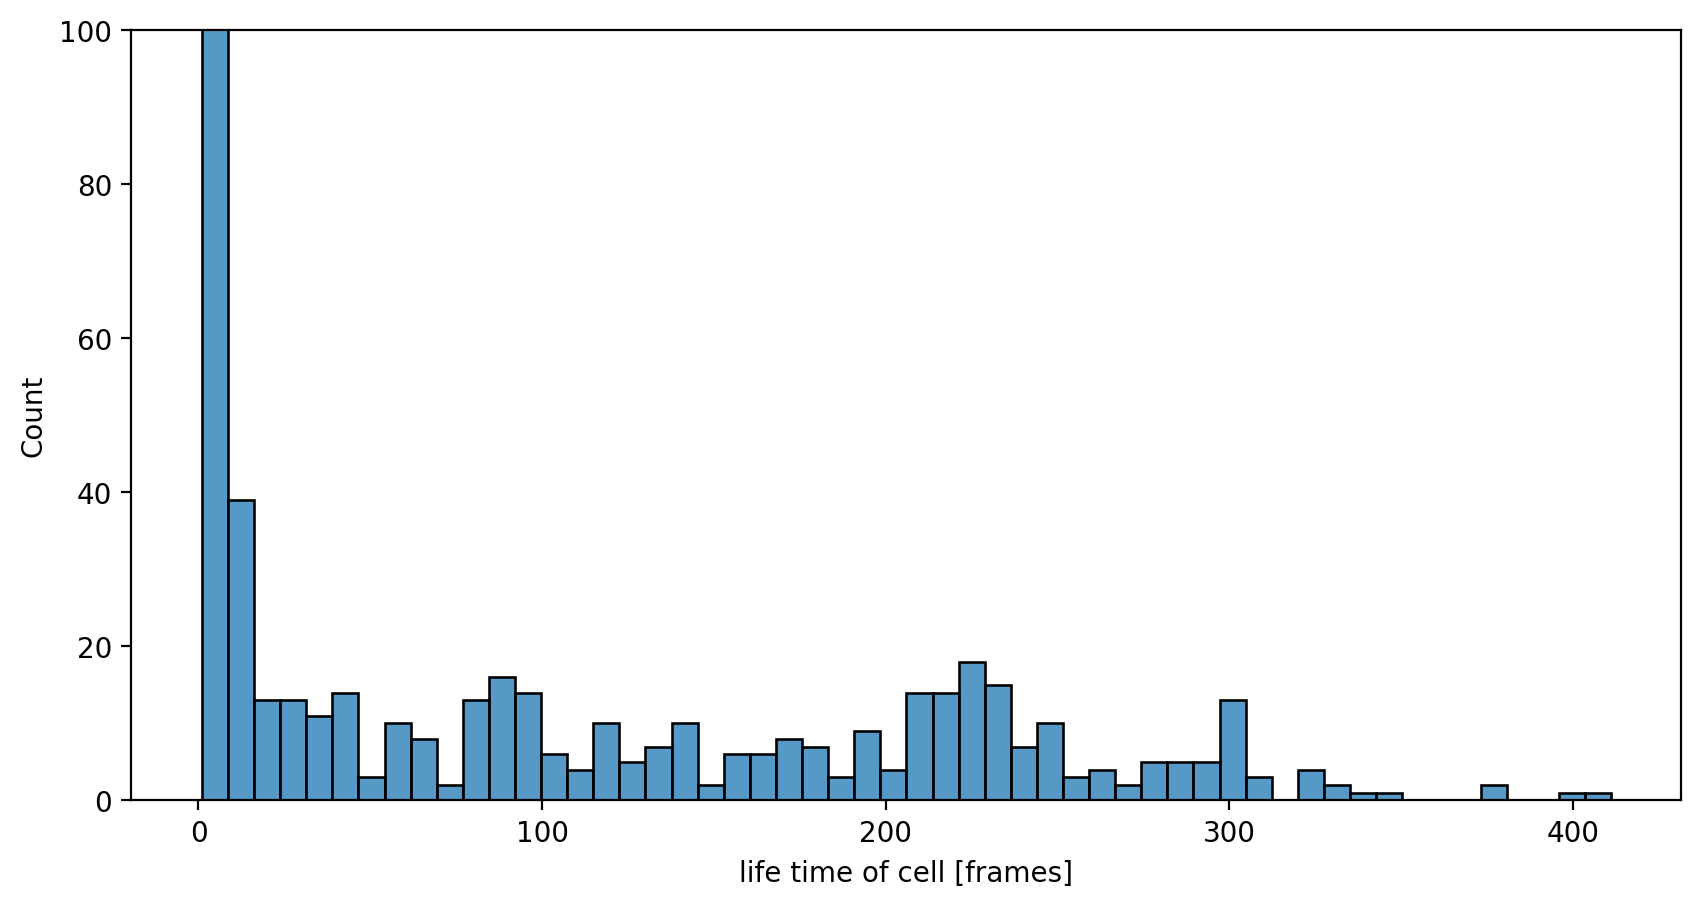

In [4]:
#plot cell life_time for full lineages
has_mom = df["id_par"] > -1
full_lin = has_mom 

df_compl = df[full_lin].copy()
ax = sns.histplot(data=df_compl.groupby('uni_id').size())
ax.set_xlabel('life time of cell [frames]');
ax.set_ylim([0,100])

Next we analyze the change in length between two frames

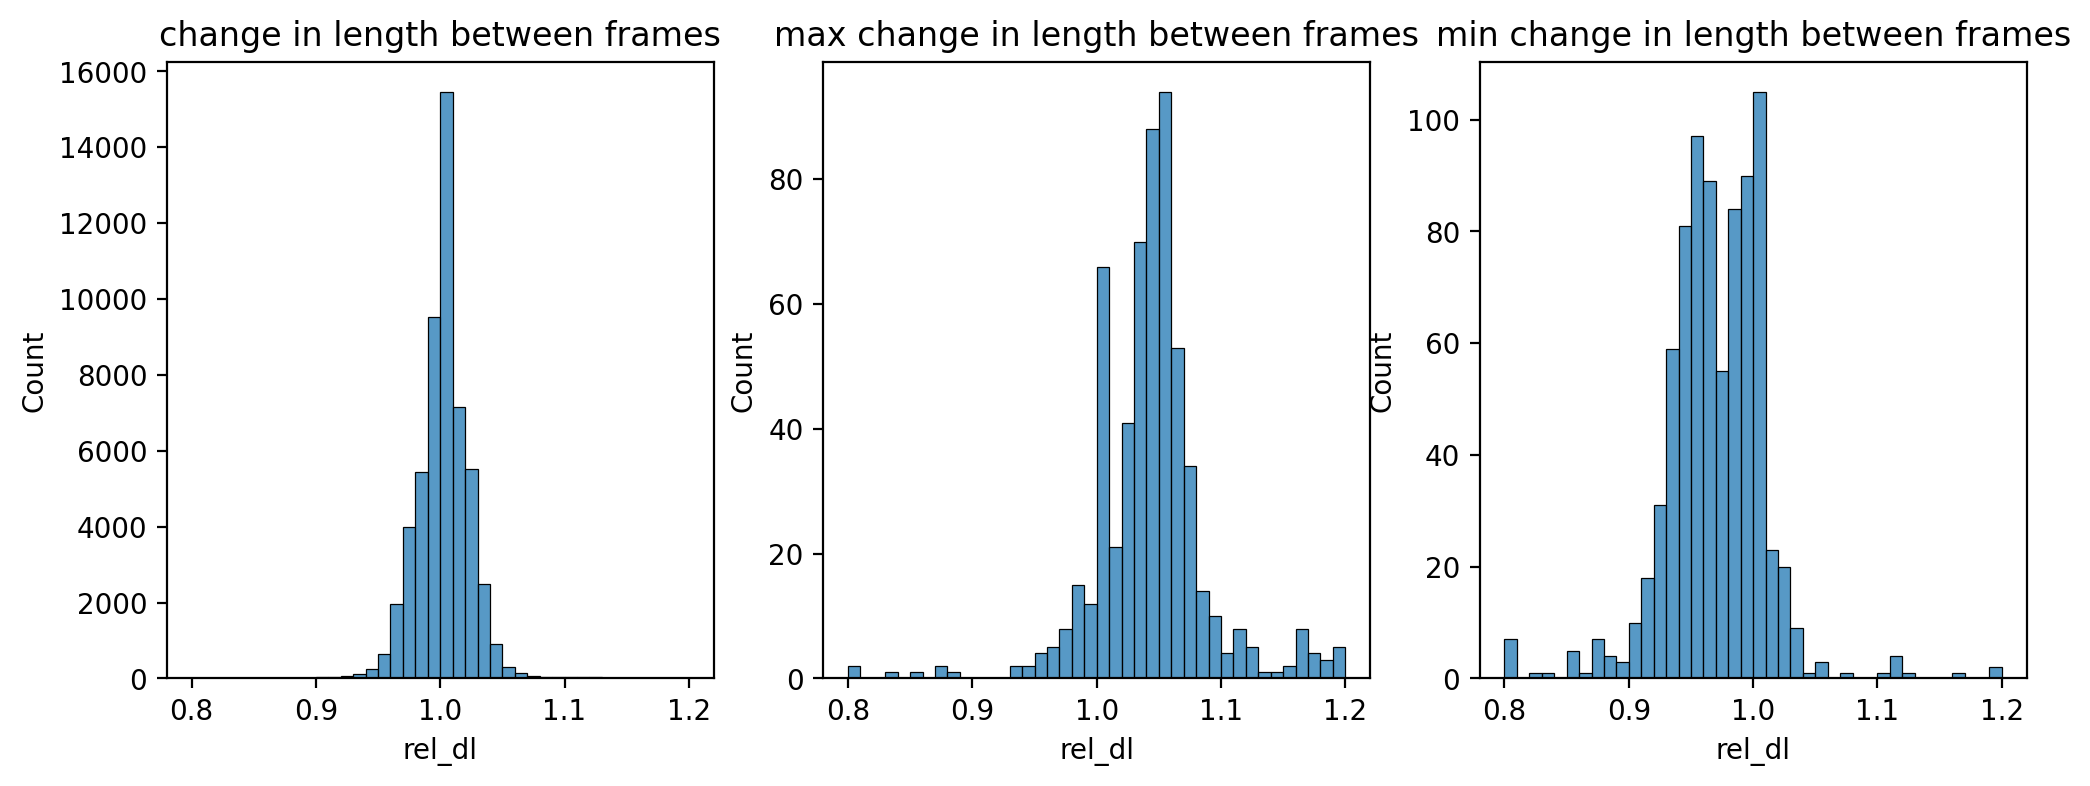

In [5]:
#calc length change
dl = df_compl.groupby('uni_id')['length'].diff()
df_compl['rel_dl'] = (df_compl['length'] + dl)/df_compl['length']
max_dl = df_compl.groupby('uni_id')['rel_dl'].max()
min_dl = df_compl.groupby('uni_id')['rel_dl'].min()

fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axs[0], data=df_compl, x='rel_dl', bins=np.linspace(0.8,1.2,41)).set(title='change in length between frames')
sns.histplot(ax=axs[1], data=max_dl, bins=np.linspace(0.8,1.2,41)).set(title='max change in length between frames')
sns.histplot(ax=axs[2], data=min_dl, bins=np.linspace(0.8,1.2,41)).set(title='min change in length between frames');

Next we analyze the change in length across cell divisions 

---

## Filter data

We use following checks:

 - We only consider cells whose division is properly tracked (both daughters are identified) and where both offspring cells are tracked for at least 12 frames (1h)
 - We filter out lineages where length changes too much between division
   - We calculate length change as $\frac{l_{d1}+l_{d2}}{l_p}$
 - We filter out lineages where the length changes too much during life time
    - We calculate length change as $\frac{l(t+\Delta t)}{l(t)} = 2^{\Delta t / t_d}$

In [6]:
def check_growth(length, min_dl, max_dl):
    """Check if change in length between frames stays within bounds

    Parameters
    ----------
    len : np.array
        length of cell over time
    min_dl : float
        lowest value of l(t+1)/l(t) that is allowed
    max_dl : float
        highest value of l(t+1)/l(t) that is allowed

    Returns
    -------
    Boolean
        True if  min_dl < l(t+1)/l(t) < max_dl for all t; false otherwise
    """
    dl = length[1:] / length[0:-1]
    
    len_ok = np.logical_and(dl>min_dl, dl<max_dl)
    
    if np.all(len_ok):
        max_frm = length.size
    elif len_ok[0]:
        max_frm = np.argmax(np.logical_not(len_ok))
    else:
        max_frm = 0
    
    return max_frm


def filter_tracks(df, cur_cell, filter_par, reason_skipped):
    """Filter cell tracks based on criteria

    Parameters
    ----------
    cur_cell : pd.DataFrame 
        grouped by DataFrame containing data of single cell
    filter_par : dictionary
        dictionary with filter parameter
    reason_skipped : dictionary
        dictionary that tracks reason why cell was skipped 

    Returns
    -------
    pd.DataFrame or None
        If tracking passes all criteria output is a DataFrame containing paired data of both offspring cells of cur_cell, else a None is returned 
    """
    
    #columns to copy
    cols = ['uni_id', 'strain', 'movie_name', 'replicate', 'id_colony', 
            'id_par', 'frames', 'generation', 'age', 'fluo1','fluo2','length']
    
    #init output
    new_df = None
    
    #check if division was tracked (non paired)
    has_p = cur_cell["id_par"].iloc[0] > -1
    if not has_p: reason_skipped['division not tracked'] += 1

    if has_p:
                
        #get offspring cells    
        #check if cell has been tracked for enough frames
        frames_ok = cur_cell.shape[0] >= filter_par['min_num_frm']
        if not frames_ok: reason_skipped['too few frames'] +=1

        if frames_ok:
            #check length change across division    
            # [l(offspring 1, t=0) +  l(offspring 2, t=0)] / l(mother, t=last)                   
        
            #check length change over time  
            max_frm = check_growth(cur_cell['length'].values, filter_par['min_dl'], filter_par['max_dl']) 
            
            len_ok = max_frm > filter_par['min_num_frm']
            
            if not len_ok: reason_skipped['dL error'] +=1

            if len_ok:
                
                
                #check length parent
                par_id = cur_cell["uni_par_id"].iloc[0]
                
                #relative length of parent just before division compared to cell after division 
                par_len = df[df['uni_id']=='AKS1092-1-7']['length'].iloc[-1] / cur_cell["length"].iloc[0]
                
                div_ok = (par_len > filter_par['min_par_len']) and par_len < filter_par['max_par_len']
                
                if not div_ok: reason_skipped['bad division'] +=1
                if div_ok:
                
                    #cell ok, process
                    reason_skipped['properly tracked'] +=1
        
                    #copy data frame   
                    new_df = cur_cell[cols].reset_index(drop=True)
                    
                    #add new fields to df
                    new_df['cdg'] =  new_df[filter_par['cdg_ch']] 
                    
                    new_df['cdg_rel'] =  new_df[f'fluo1'] / new_df[f'fluo2'] 
                    
                    new_df = new_df[:filter_par['max_num_frm']]
                   

    return new_df

These are the filter settings we use:

- `min_par_len`: the minimal value of the relative length of the parent (to make sure we start at cell-division)
- `max_dl`: max value $l(t+1)/l(t)$ 
- `min_dl`: min value $l(t+1)/l(t)$ 
- `min_num_frm`: min number of frames to track 
- `cdg_ch`: cdg channel name

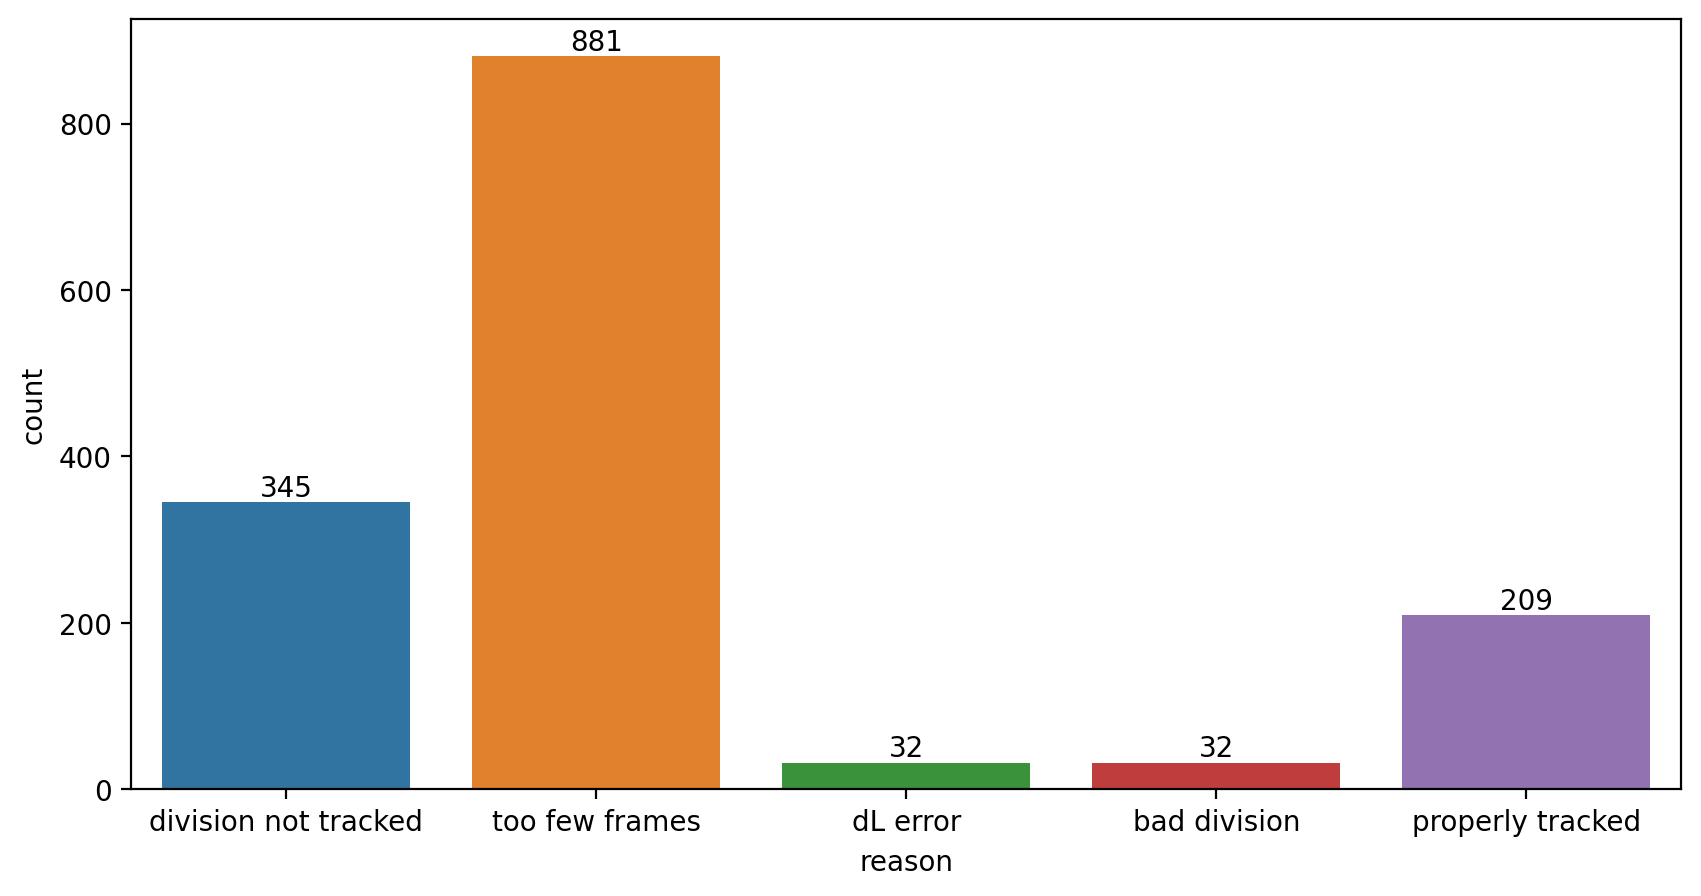

In [7]:
#filter settings
filter_par = {
        'max_par_len' : 2.5,
        'min_par_len' : 1.5,
        'max_dl': 1.08,  
        'min_dl': 0.92,  
        'min_num_frm': 60,
        'max_num_frm' : 120,
        'cdg_ch': 'fluo1'}


#keep track of why lineages are skipped
reason_skipped = { \
        'division not tracked':0,
        'too few frames':0,
        'dL error':0,
        'bad division':0,
        'properly tracked':0}

#init output
df_list = []

cells_grouped = df.groupby('uni_id') 
for _, cur_cell in cells_grouped:
        # filter cells    
        new_df = filter_tracks(df, cur_cell, filter_par, reason_skipped)
        if new_df is not None:
                df_list.append(new_df)
        
              
df_filtered = pd.concat(df_list) if len(df_list)>0 else None   

df_filtered['time since birth [min]'] = df_filtered['age'] * 0.5
df_filtered = df_filtered.reset_index(drop=True)

out_name = save_dir / 'filtered_data_Cc_Fast.csv'
df_filtered.to_csv(out_name)
 
df_stats = pd.DataFrame( [ [k,v] for k,v in reason_skipped.items()],columns=['reason','count'])
ax = sns.barplot(data=df_stats, x='reason', y='count')
ax.bar_label(ax.containers[0]);

## Add cdg treshhold

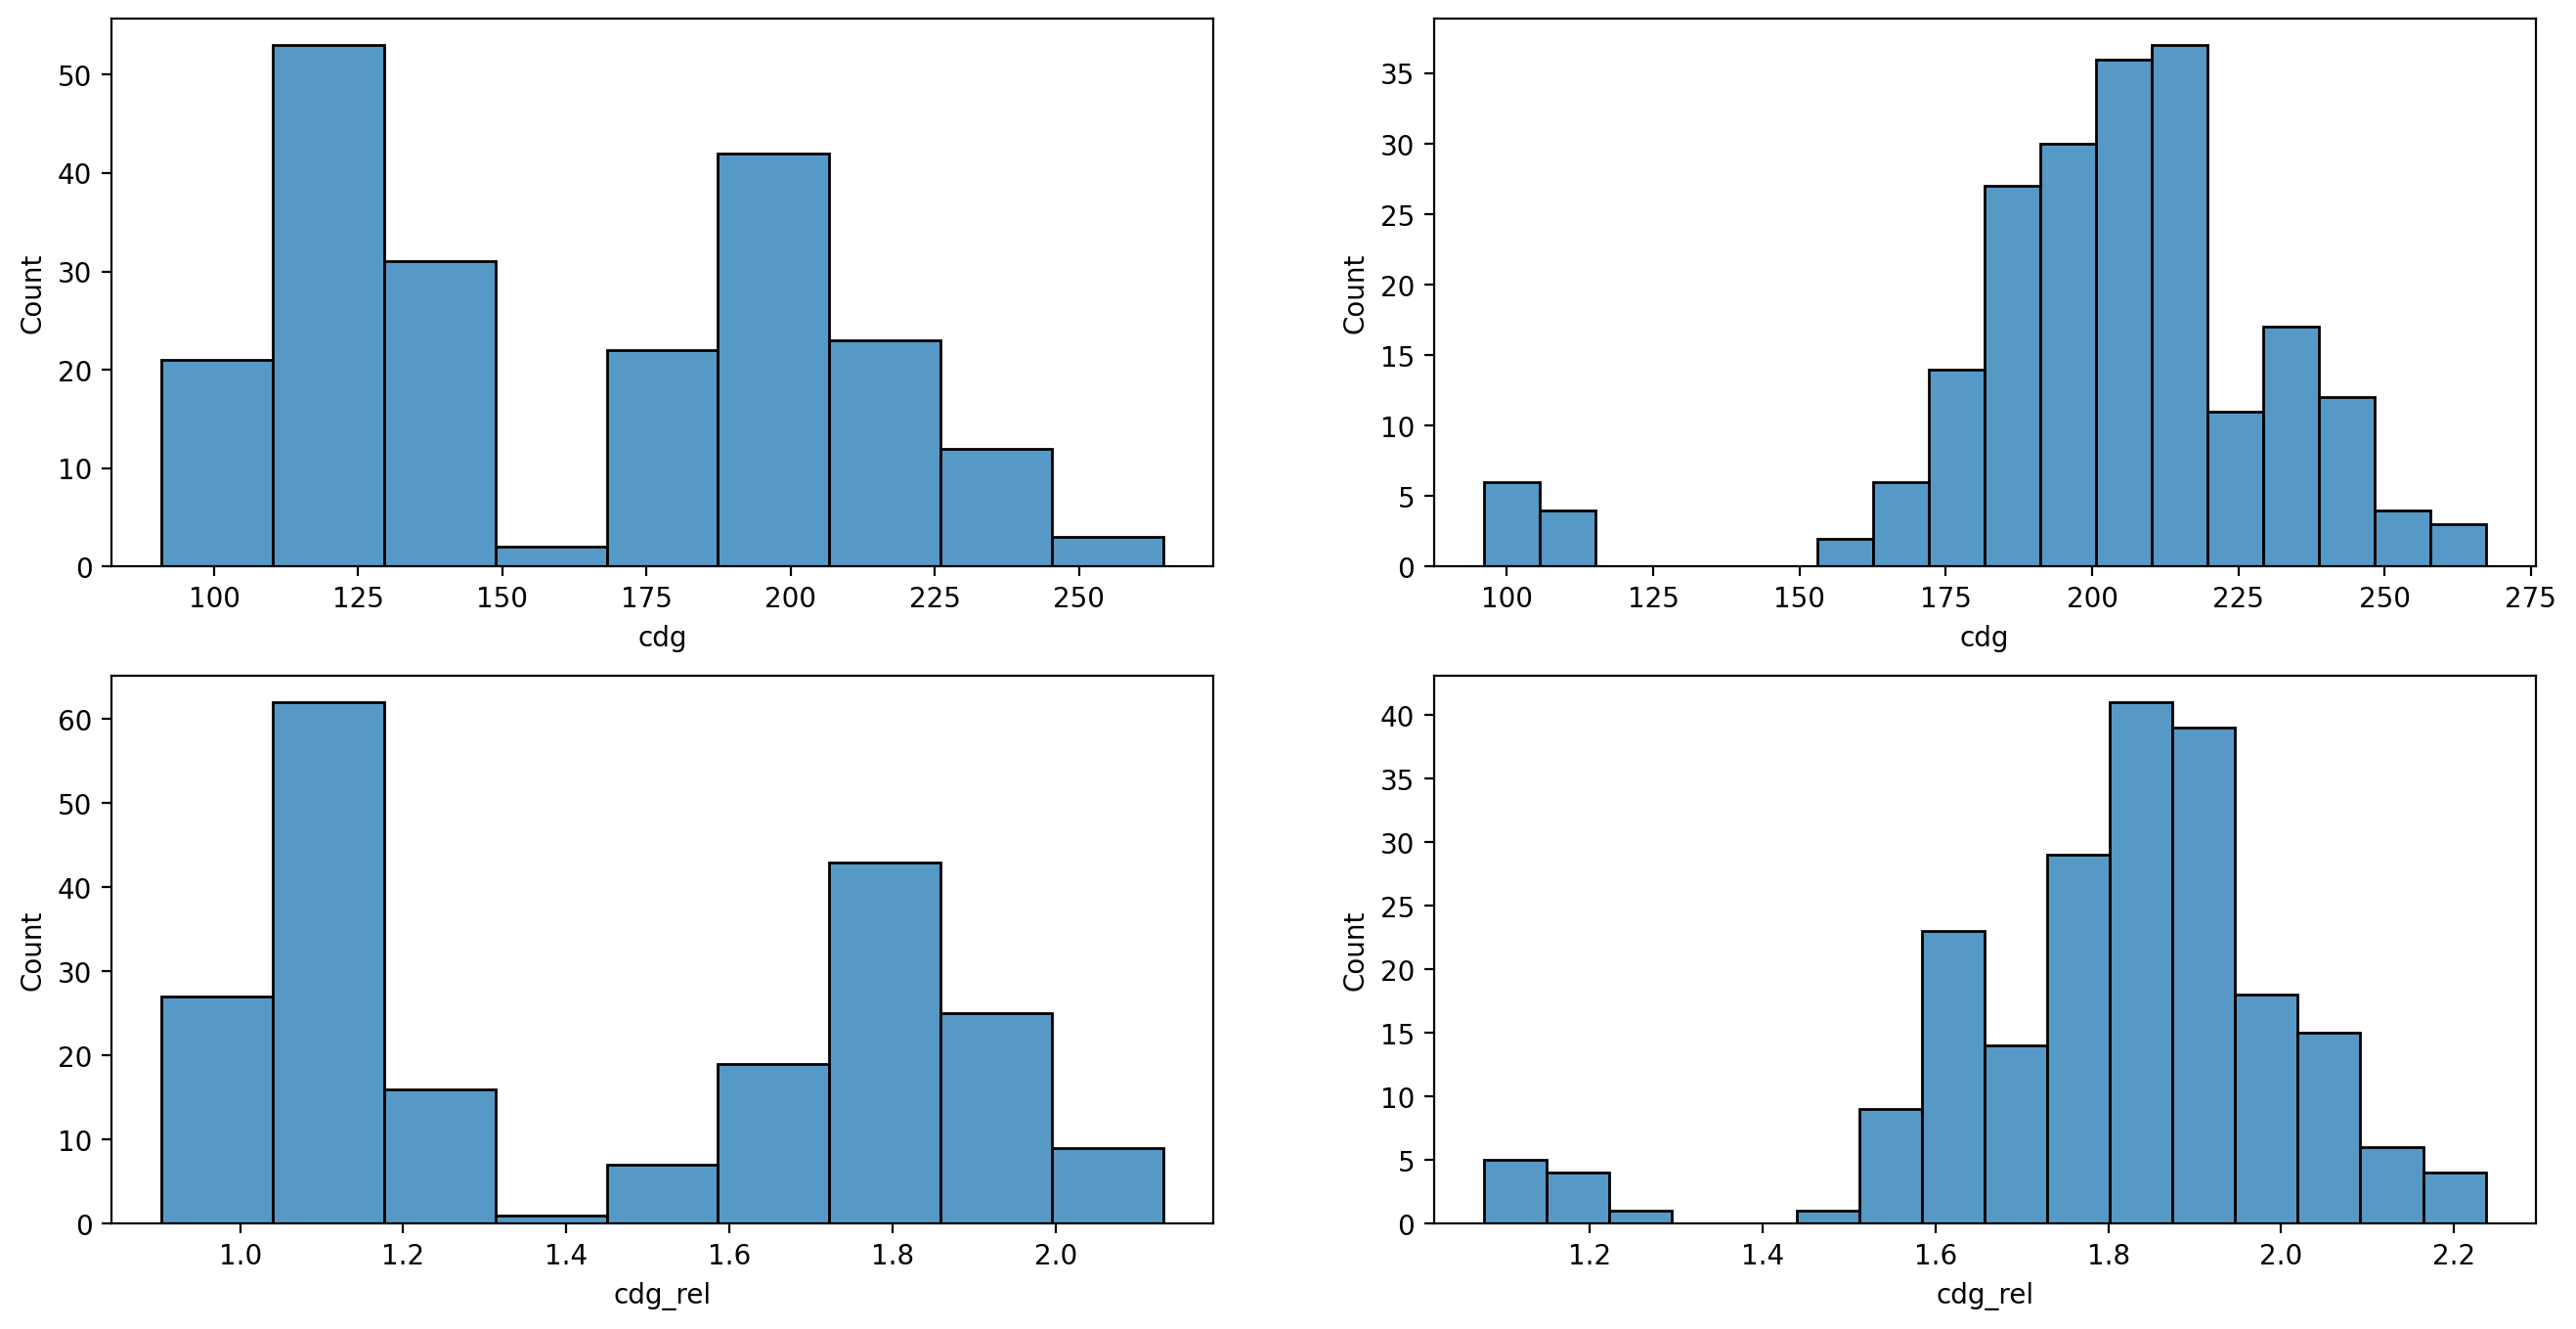

In [8]:
fig, axs = plt.subplots(2,2,figsize=(16,8))

sns.histplot(data=df_filtered.groupby('uni_id').min(), x='cdg', ax=axs[0,0])
sns.histplot(data=df_filtered[df_filtered['age']==0], x='cdg', ax=axs[0,1])

sns.histplot(data=df_filtered.groupby('uni_id').min(), x='cdg_rel', ax=axs[1,0])
sns.histplot(data=df_filtered[df_filtered['age']==0], x='cdg_rel', ax=axs[1,1])

cdg_tresh = 150
cdg_rel_tresh = 1.4
df_filtered['cdg_type'] = df_filtered.groupby('uni_id')['cdg'].transform(lambda x: 'high' if np.min(x) > cdg_tresh else 'low' )
df_filtered['ok_cell'] = df_filtered.groupby('uni_id')['cdg'].transform(lambda x: True if x.iloc[0]>cdg_tresh else False )

df_filtered['cdg_rel_type'] = df_filtered.groupby('uni_id')['cdg_rel'].transform(lambda x: 'high' if np.min(x) > cdg_rel_tresh else 'low' )
df_filtered['ok_rel_cell'] = df_filtered.groupby('uni_id')['cdg_rel'].transform(lambda x: True if x.iloc[0]>cdg_rel_tresh else False )

In [9]:
#add cdg production rate
def derivative(y, frm_interval=1, log = False):
    if y.size > 2:
        y = np.log(y) if log else y
        x = np.arange(y.size) * frm_interval
        p = np.polyfit(x, y, 1) #simply 1st order polynomial fit / regression (numpy.polyfit)
        ddt = p[0] #slope of first order fit in python p[0]
    else: 
        ddt = np.nan 
    return ddt 

def calc_promoter_activity(df, channel, fit_window=5, frm_interval=1, gamma=0.0015):
    min_periods = int(np.ceil(fit_window/2))
    
    ddt_fluor = df.groupby('uni_id')[channel].rolling(fit_window, min_periods=min_periods, center=True).apply(derivative, kwargs={'frm_interval':frm_interval}).reset_index(0,drop=True)
    return (gamma + df['elongation_rate'] ) * df[channel] + ddt_fluor   

def calc_ddt(df, channel, fit_window=5, frm_interval=1, gamma=0.0015):
    min_periods = int(np.ceil(fit_window/2))
    ddt_fluor = df.groupby('uni_id')[channel].rolling(fit_window, min_periods=min_periods, center=True).apply(derivative, kwargs={'frm_interval':frm_interval}).reset_index(0,drop=True)
    return ddt_fluor   


def calc_elengation_rate(df, lengthname='length', fit_window=5, frm_interval=1):
    min_periods = int(np.ceil(fit_window/2))
    return df.groupby('uni_id')['length'].rolling(fit_window, min_periods=min_periods, center=True).apply(derivative, kwargs={'frm_interval':frm_interval, 'log':True}).reset_index(0,drop=True)


def calc_smooth(df, field, fit_window=5):
    min_periods = int(np.ceil(fit_window/2))
    return df.groupby('uni_id')[field].rolling(fit_window, min_periods=min_periods, center=True).apply(lambda x: x.mean()).reset_index(0,drop=True)


frm_interval = 0.5 #frame interval in minutes

df_filtered['elongation_rate'] = calc_elengation_rate(df_filtered, fit_window=7, frm_interval=frm_interval)
df_filtered['ddt_cdg'] = calc_ddt(df_filtered, 'fluo1', fit_window=7, frm_interval=frm_interval)
df_filtered['cdg_smooth'] = calc_smooth(df_filtered, 'cdg', fit_window=5)

df_filtered['age_of_peak'] = df_filtered.groupby('uni_id')['ddt_cdg'].transform(lambda x: np.argmax(x))
df_filtered['relative time [min]'] = df_filtered['time since birth [min]'] - df_filtered['age_of_peak']*0.5

df_filtered['age_of_val'] = df_filtered.groupby('uni_id')['cdg_smooth'].transform(lambda x: np.argmin(x))
df_filtered['relative time 2 [min]'] = df_filtered['time since birth [min]'] - df_filtered['age_of_val']*0.5


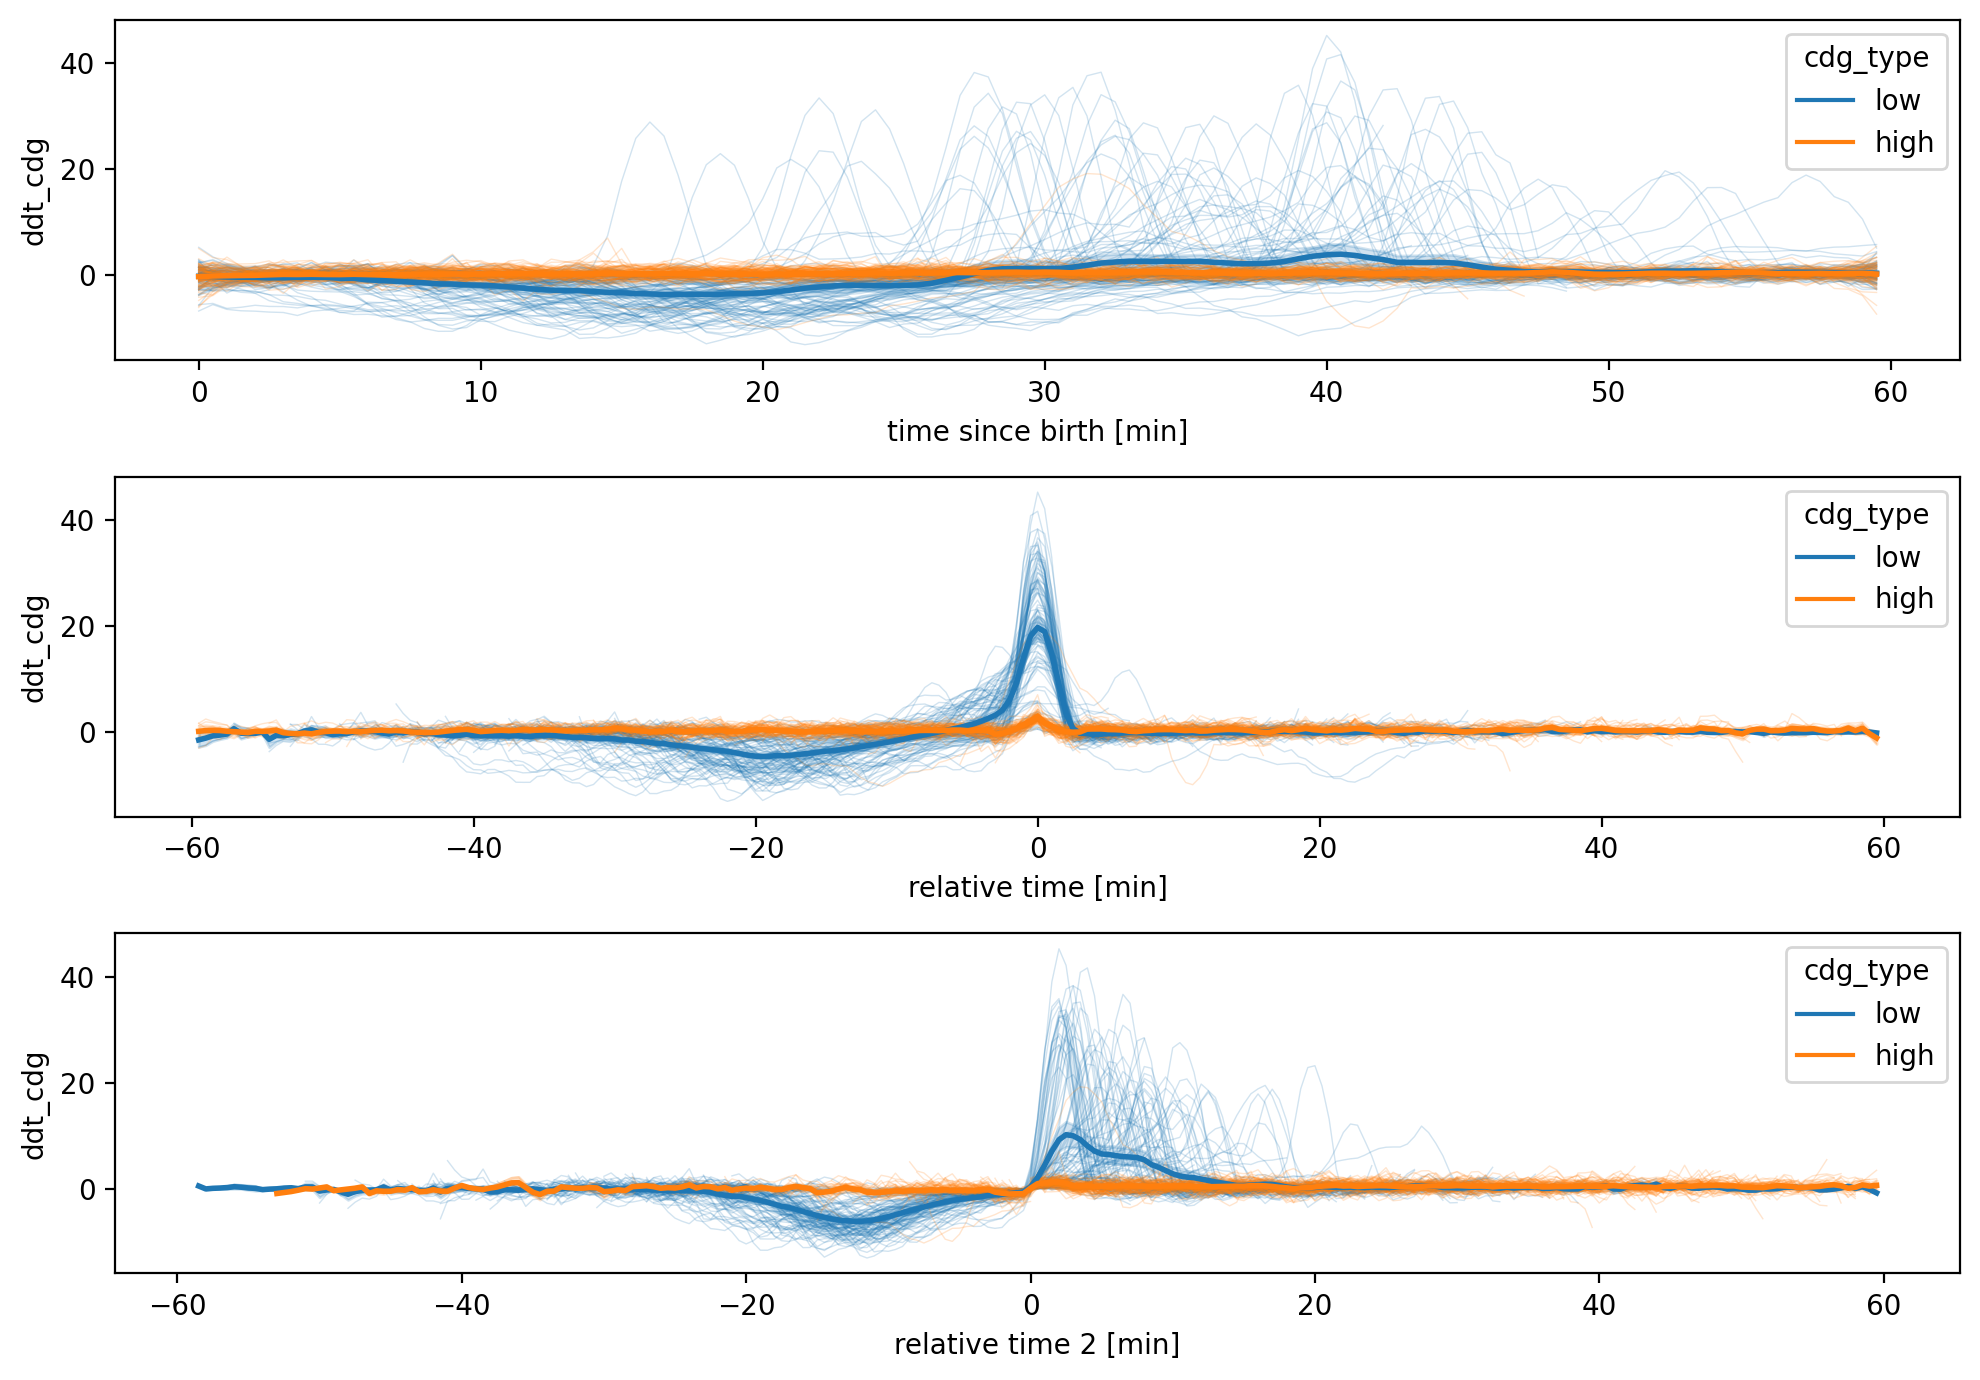

In [10]:
fig, axs = plt.subplots(3,1,figsize=(10,7))
data_fig = df_filtered

sns.lineplot(data=data_fig, x='time since birth [min]', y='ddt_cdg', hue='cdg_type', ax=axs[0], units='uni_id',estimator=None, lw=0.5, legend=False, alpha=0.2);
sns.lineplot(data=data_fig, x='time since birth [min]', y='ddt_cdg', hue='cdg_type', ax=axs[0], lw=2);
plt.tight_layout()

sns.lineplot(data=data_fig, x='relative time [min]', y='ddt_cdg', hue='cdg_type', ax=axs[1], units='uni_id',estimator=None, lw=0.5, legend=False, alpha=0.2);
sns.lineplot(data=data_fig, x='relative time [min]', y='ddt_cdg', hue='cdg_type', ax=axs[1], lw=2);

sns.lineplot(data=data_fig, x='relative time 2 [min]', y='ddt_cdg', hue='cdg_type', ax=axs[2], units='uni_id',estimator=None, lw=0.5, legend=False, alpha=0.2);
sns.lineplot(data=data_fig, x='relative time 2 [min]', y='ddt_cdg', hue='cdg_type', ax=axs[2], lw=2);
plt.tight_layout()


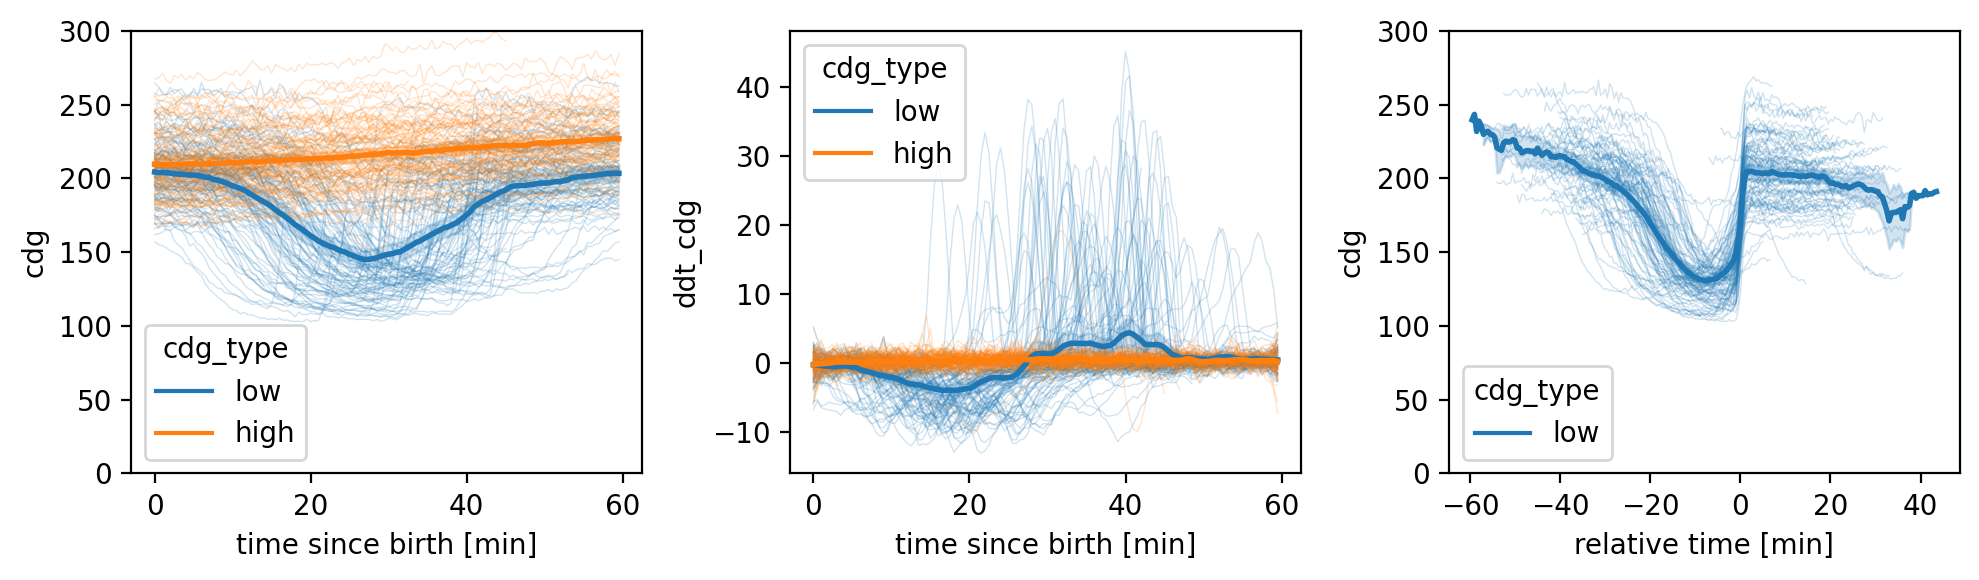

In [11]:
fig, axs = plt.subplots(1,3,figsize=(10,3))
data_fig0 = df_filtered[df_filtered['ok_cell']]
data_fig1 = df_filtered.loc[df_filtered['ok_cell'] & (df_filtered['cdg_type']=='low')]

sns.lineplot(data=data_fig0, x='time since birth [min]', y='cdg', hue='cdg_type', 
             ax=axs[0], units='uni_id', estimator=None, lw=0.5, legend=False, alpha=0.2).set_ylim((0,300));
sns.lineplot(data=data_fig0, x='time since birth [min]', y='cdg', hue='cdg_type', 
             ax=axs[0], lw=2).set_ylim((0,300));


sns.lineplot(data=data_fig0, x='time since birth [min]', y='ddt_cdg', hue='cdg_type', 
             ax=axs[1], units='uni_id', estimator=None, lw=0.5, legend=False, alpha=0.2);
sns.lineplot(data=data_fig0, x='time since birth [min]', y='ddt_cdg', hue='cdg_type', 
             ax=axs[1], lw=2);


sns.lineplot(data=data_fig1, x='relative time [min]', y='cdg', hue='cdg_type', 
             ax=axs[2], units='uni_id',estimator=None, lw=0.5, legend=False, alpha=0.2).set_ylim((0,300));
sns.lineplot(data=data_fig1, x='relative time [min]', y='cdg', hue='cdg_type', 
             ax=axs[2], lw=2).set_ylim((0,300));

plt.tight_layout()

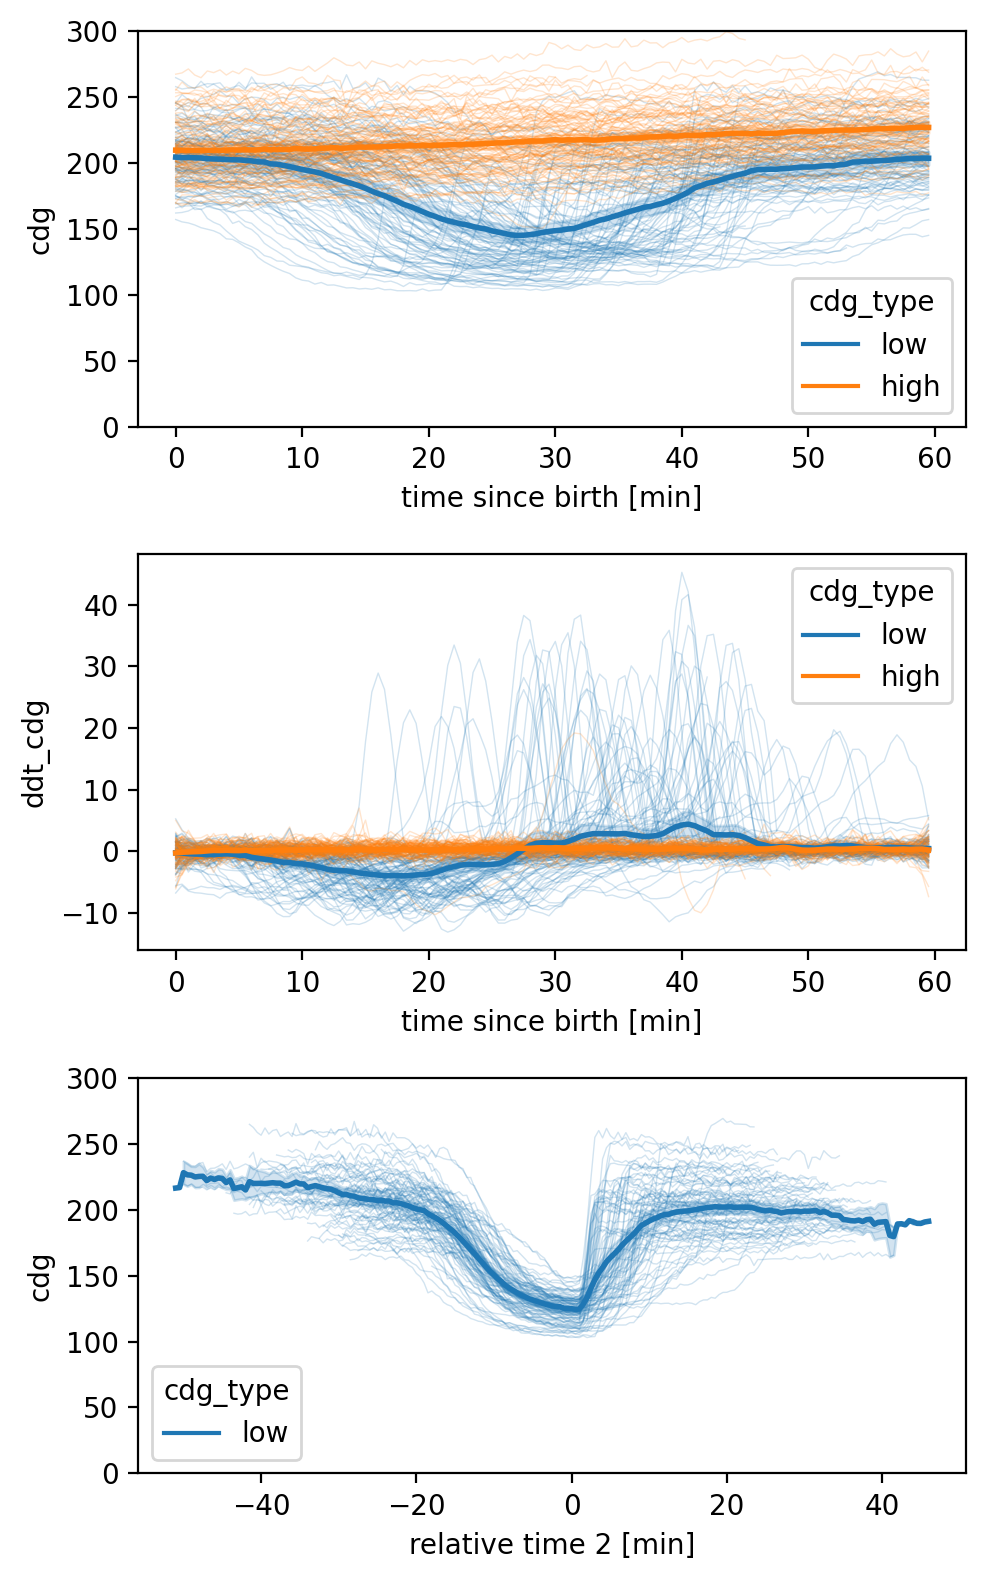

In [12]:

fig, axs = plt.subplots(3,1,figsize=(5,8))
data_fig0 = df_filtered[df_filtered['ok_cell']]
data_fig1 = df_filtered.loc[df_filtered['ok_cell'] & (df_filtered['cdg_type']=='low')]

sns.lineplot(data=data_fig0, x='time since birth [min]', y='cdg', hue='cdg_type', 
             ax=axs[0], units='uni_id', estimator=None, lw=0.5, legend=False, alpha=0.2).set_ylim((0,300));
sns.lineplot(data=data_fig0, x='time since birth [min]', y='cdg', hue='cdg_type', 
             ax=axs[0], lw=2).set_ylim((0,300));


sns.lineplot(data=data_fig0, x='time since birth [min]', y='ddt_cdg', hue='cdg_type', 
             ax=axs[1], units='uni_id', estimator=None, lw=0.5, legend=False, alpha=0.2);
sns.lineplot(data=data_fig0, x='time since birth [min]', y='ddt_cdg', hue='cdg_type', 
             ax=axs[1], lw=2);


sns.lineplot(data=data_fig1, x='relative time 2 [min]', y='cdg', hue='cdg_type', 
             ax=axs[2], units='uni_id',estimator=None, lw=0.5, legend=False, alpha=0.2).set_ylim((0,300));
sns.lineplot(data=data_fig1, x='relative time 2 [min]', y='cdg', hue='cdg_type', 
             ax=axs[2], lw=2).set_ylim((0,300));

plt.tight_layout()

im_name = image_dir / 'cdg_fast_dynamics.svg'
fig.savefig(im_name)

In [24]:
#count number of unique cells
df_filtered['uni_id'].unique().size

209